<a href="https://colab.research.google.com/github/Medilan8D/wengardiamleviossa/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
housing = pd.read_csv('/content/sample_data/housing.csv.zip' ,compression='zip')


In [ ]:
print('Quick view at the dataset:')

housing.head(5).style.set_properties(**{'background-color':'#2a9d8f','color':'white','border':'2.5px solid black'})


Quick view at the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,NEAR BAY
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,NEAR BAY
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,NEAR BAY
3,-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000,NEAR BAY
4,-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000,NEAR BAY


In [ ]:
print(f'Total Number of datapoints: {len(housing)}')
print(f'Shape of the dataset: {housing.shape}')

Total Number of datapoints: 20640
Shape of the dataset: (20640, 10)


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
print('Summary of the dataset:')

housing.describe().T.style.set_properties(**{'background-color':'#2a9d8f', 'color':'white', 'border':'2.5px solid black'})


Summary of the dataset:


,count,mean,std,min,25%,50%,75%,max
longitude,20640.000000,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20640.000000,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
housing_median_age,20640.000000,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20640.000000,2635.763081,2181.615252,2.000000,1447.750000,2127.000000,3148.000000,39320.000000
total_bedrooms,20433.000000,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20640.000000,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
households,20640.000000,499.539680,382.329753,1.000000,280.000000,409.000000,605.000000,6082.000000
median_income,20640.000000,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
median_house_value,20640.000000,206855.816909,115395.615874,14999.000000,119600.000000,179700.000000,264725.000000,500001.000000


In [ ]:
print('Null values in the dataset:')

housing.isna().sum().to_frame().T.style.set_properties(**{'background-color':'#2a9d8f', 'color':'white', 'border':'2.5px solid black'})


Null values in the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,0,0,0,207,0,0,0,0,0


In [ ]:
print('Number of Unique values in the dataset:')

housing.nunique().to_frame().style.set_properties(**{'background-color':'#2a9d8f', 'color':'white', 'border':'2.5px solid black'})


Number of Unique values in the dataset:


,0
longitude,844
latitude,862
housing_median_age,52
total_rooms,5926
total_bedrooms,1923
population,3888
households,1815
median_income,12928
median_house_value,3842
ocean_proximity,5


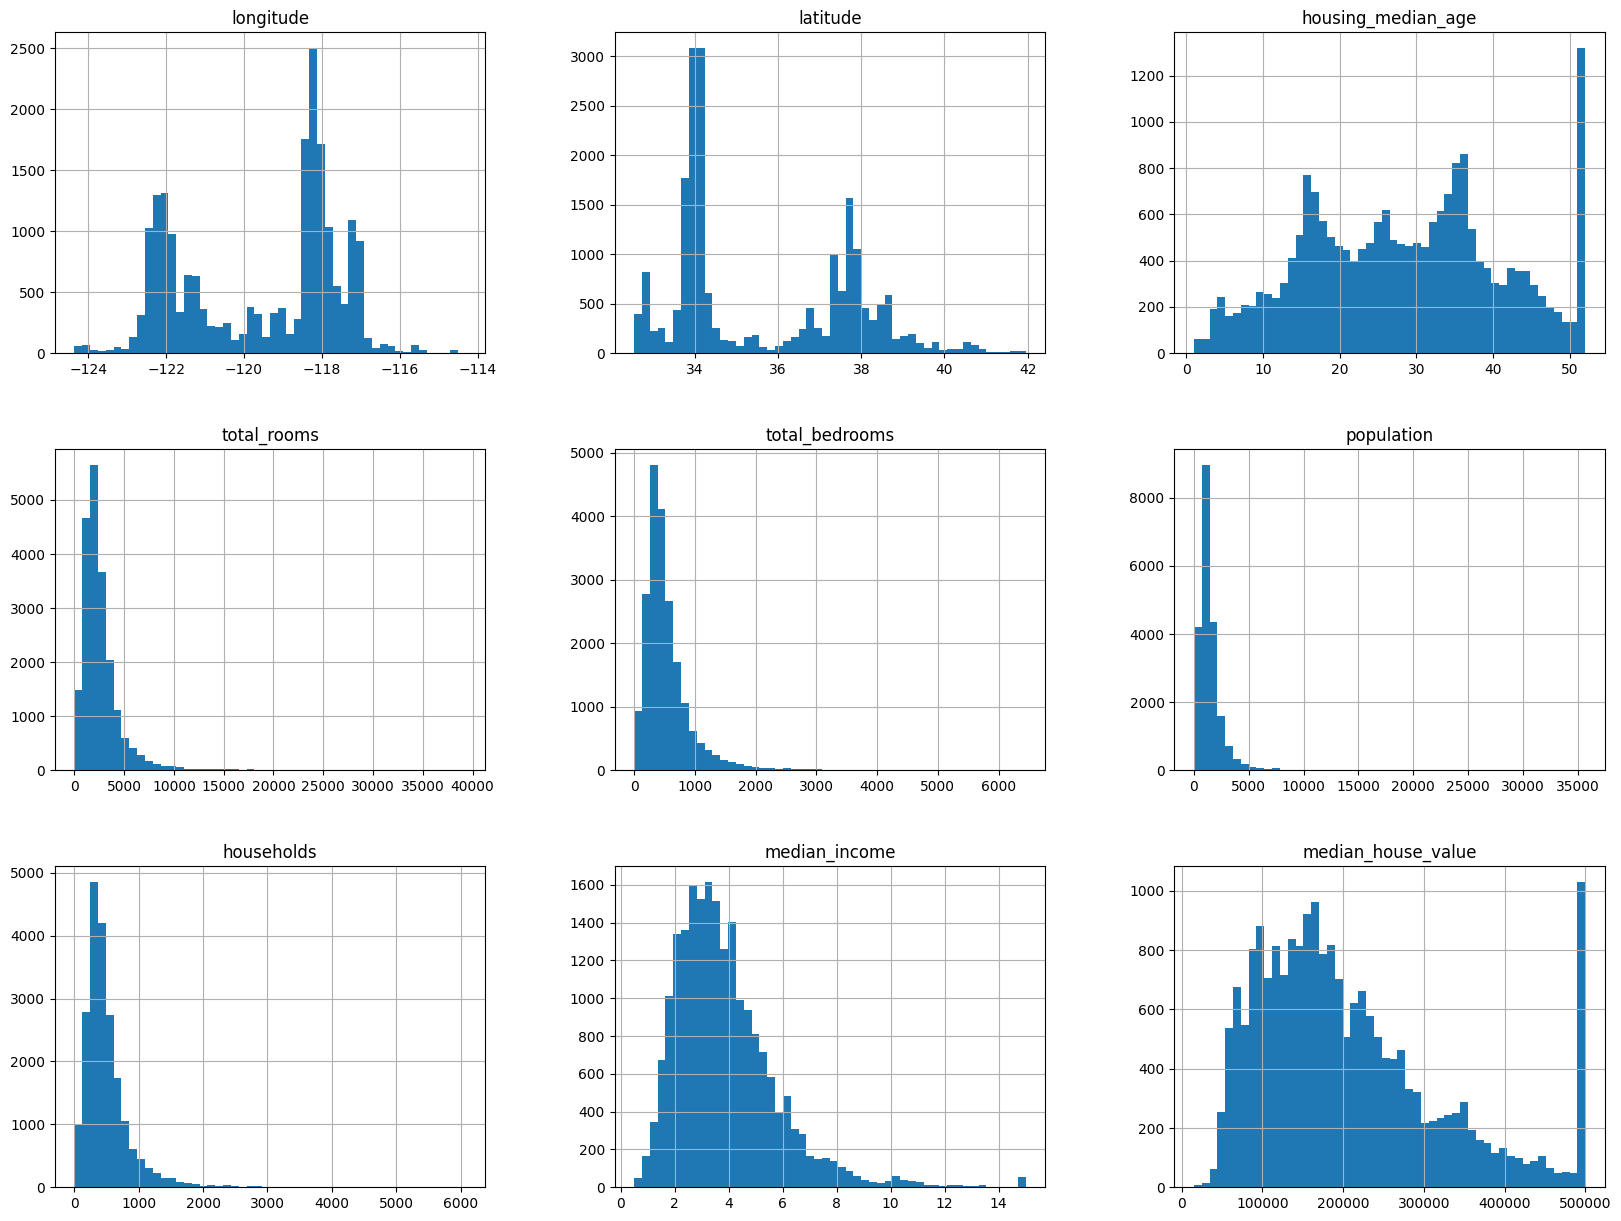

In [ ]:
# Plot histograms
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [ ]:
#setting custom palette
sns.set_style("white")
sns.set_context("poster",font_scale = .7)

palette = ["#1d7874","#679289","#f4c095","#ee2e31","#ffb563","#918450","#f85e00","#a41623","#9a031e","#d6d6d6","#ffee32","#ffd100","#333533","#202020"]


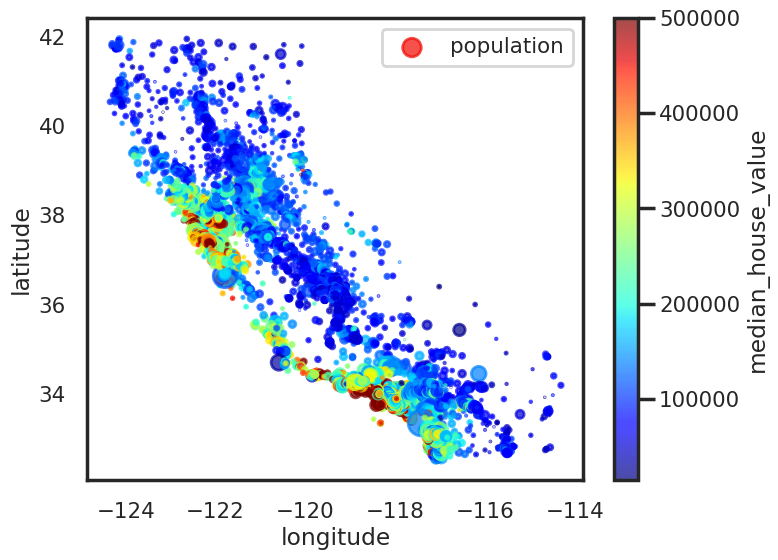

In [ ]:
# Scatter plot: longitude vs latitude
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.7,
             s=housing["population"]/100, label="population", figsize=(8,6),
             c="median_house_value", cmap= plt.get_cmap('jet'), colorbar=True,
             sharex=False)
plt.legend()

In [ ]:
#  Custome function to plot histogram
def histplot(data, x, title, xlabel, col=None):
    fig,ax=plt.subplots(figsize=(12,6))
    plt.tight_layout(pad=6.0)

    sns.histplot(data[x], color=col, kde=True, bins='auto', alpha=1, fill=True, edgecolor="#1c1c1c")
    ax.lines[0].set_color(palette[12])
    ax.set_title(f'\n{title}', fontsize=25)
    ax.set_xlabel(f'{xlabel}\n')
    ax.set_ylabel('Total Count')

    sns.despine(left=True, bottom=True)
    plt.show()


#  Custome function to plot countplot
def countplot(data, x, xlabel, title, col=None):
    fig,ax=plt.subplots(figsize=(12,8))
    plt.tight_layout(pad=6.0)
    sns.countplot(x=data[x], palette=col[1:], edgecolor="#1c1c1c", linewidth=2)
    ax.set_title(f"\n{title}", fontsize=25)
    ax.set_xlabel(f"{xlabel}\n")
    total = len(data)
    for p in ax.patches:
        count = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y, f'{count}', ha='center', va='bottom')
    plt.show()

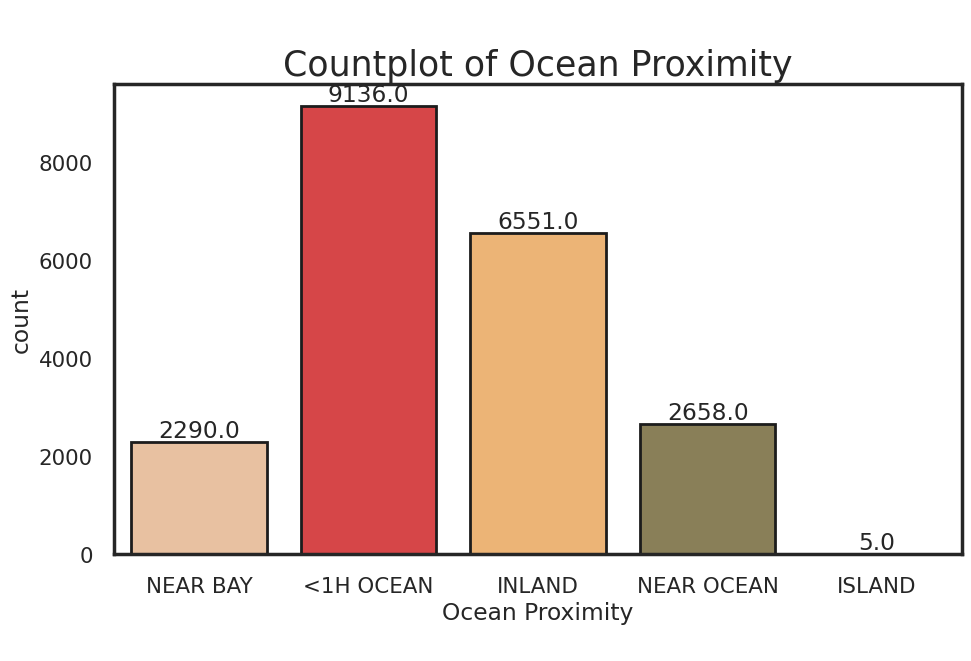

In [ ]:
# Count plot for ocean proximity
countplot(housing,'ocean_proximity', xlabel ='Ocean Proximity', title = 'Countplot of Ocean Proximity', col= palette[1:])


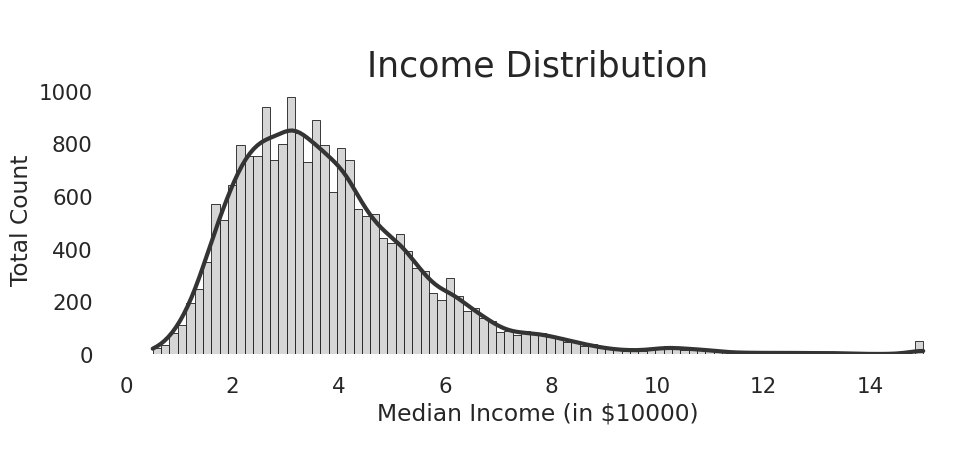

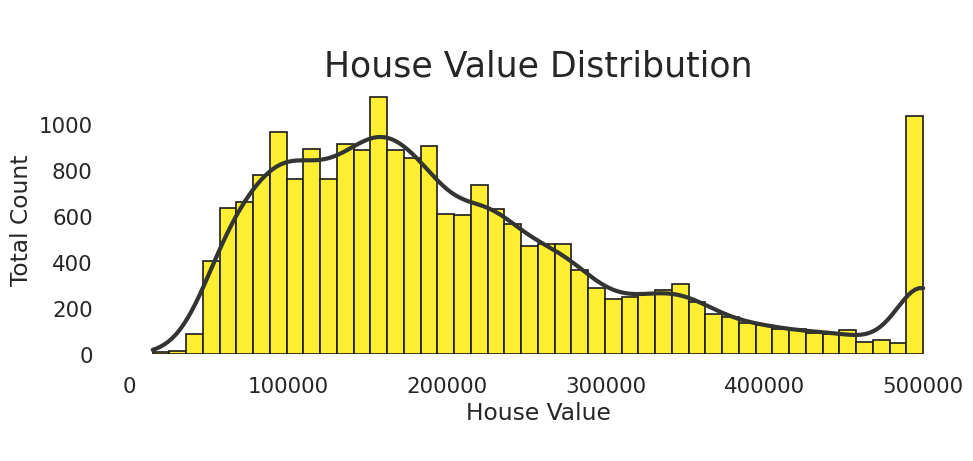

In [ ]:
# Histogram for median income distribution
histplot(data= housing, x='median_income', title='Income Distribution', xlabel='Median Income (in $10000)',col=palette[9])

# Histogram for house value distribution
histplot(data= housing, x='median_house_value', title='House Value Distribution', xlabel='House Value', col=palette[10])


In [ ]:
# Select numerical columns
numerical_features= [col for col in housing.columns if housing.dtypes[col] in ['float', 'int']]

# Compute Pearson correlation matrix
corr_matrix= housing[numerical_features].corr(method='pearson')


In [ ]:
# Sort correlation values for median house value
corr_matrix["median_house_value"].sort_values(ascending=False)


,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


In [ ]:
X=housing.drop("median_house_value", axis=1)
Y=housing["median_house_value"]

x_train_valid, x_test, y_train_valid, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train, x_valid, y_train, y_valid =train_test_split(x_train_valid, y_train_valid, test_size= 0.25, random_state=42)

In [ ]:
# Create a pipeline for numerical data preprocessing
num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("std_scaler", StandardScaler())
])

In [ ]:
numerical_features= [col for col in x_train.columns if x_train.dtypes[col] in ['float', 'int']]
categorical_features = [col for col in x_train.columns if x_train.dtypes[col] =='object']

# Create a full preprocessing pipeline for both types
full_pipeline=ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(), categorical_features)
])

In [ ]:
# Fit and transform the training data with the pipeline
x_train=full_pipeline.fit_transform(x_train)

# Transform the validation data using the same pipeline
x_valid=full_pipeline.transform(x_valid)


In [ ]:
# Initialize linear regression model
lr_model =LinearRegression()

# Fit model to training data
lr_model.fit(x_train, y_train)


LinearRegression()

In [ ]:
# Make predictions on the validation set
lr_pred_valid = lr_model.predict(x_valid)

print("Linear Regression Model:")
print("R2 Score:", r2_score(y_valid, lr_pred_valid))
print("Mean Absolute Error:", mean_absolute_error(y_valid, lr_pred_valid))


Linear Regression Model:
R2 Score: 0.656826254814969
Mean Absolute Error: 50101.78545243686


In [ ]:
# Make predictions on the training set
lr_pred_train = lr_model.predict(x_train)

print("Linear Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_train, lr_pred_train)))
print("Mean Absolute Error:", mean_absolute_error(y_train, lr_pred_train))
print("R2 Score:", r2_score(y_train, lr_pred_train))


Linear Regression Model:
Root Mean Squared Error: 68387.32831511954
Mean Absolute Error: 49518.40380858805
R2 Score: 0.6469268711492123


In [ ]:
# Initialize decision tree regression model
tree_model=DecisionTreeRegressor(random_state=42)

# Fit model to training data
tree_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# Make predictions on the validation set
tree_pred_valid = tree_model.predict(x_valid)

print("Decision Tree Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_valid, tree_pred_valid)))
print("Mean Absolute Error:", mean_absolute_error(y_valid, tree_pred_valid))
print("R2 Score:", r2_score(y_valid, tree_pred_valid))

Decision Tree Regression Model:
Root Mean Squared Error: 69676.89049939535
Mean Absolute Error: 44283.42441860465
R2 Score: 0.6464342067757904


In [ ]:
# Make predictions on the training set
tree_pred_train = tree_model.predict(x_train)

print("Decision Tree Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_train, tree_pred_train)))
print("Mean Absolute Error:", mean_absolute_error(y_train, tree_pred_train))
print("R2 Score:", r2_score(y_train, tree_pred_train))


Decision Tree Regression Model:
Root Mean Squared Error: 0.0
Mean Absolute Error: 0.0
R2 Score: 1.0


In [ ]:
# Initialize random forest regression model
rfr_model=RandomForestRegressor()

# Fit model to training data
rfr_model.fit(x_train, y_train)

RandomForestRegressor()

In [ ]:
# Make predictions on the validation set
rfr_pred_valid = rfr_model.predict(x_valid)

print("Random Forest Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_valid, rfr_pred_valid)))
print("Mean Absolute Error:", mean_absolute_error(y_valid, rfr_pred_valid))
print("R2 Score:", r2_score(y_valid, rfr_pred_valid))


Random Forest Regression Model:
Root Mean Squared Error: 49622.79500261917
Mean Absolute Error: 32462.31680959302
R2 Score: 0.8206690852473619


In [ ]:
# Make predictions on the training set
rfr_pred_train = rfr_model.predict(x_train)

print("Random Forest Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_train, rfr_pred_train)))
print("Mean Absolute Error:", mean_absolute_error(y_train, rfr_pred_train))
print("R2 Score:", r2_score(y_train, rfr_pred_train))

Random Forest Regression Model:
Root Mean Squared Error: 18446.370849622428
Mean Absolute Error: 11978.415438468994
R2 Score: 0.9743117060457824


In [ ]:
# Initialize LightGBM regression model
lgbm_model=LGBMRegressor(verbosity=-1)

# Fit model to training data
lgbm_model.fit(x_train, y_train)

LGBMRegressor(verbosity=-1)

In [ ]:
# Make predictions on the validation set
lgbm_pred_valid = lgbm_model.predict(x_valid)

print("Light GBM Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_valid, lgbm_pred_valid)))
print("Mean Absolute Error:", mean_absolute_error(y_valid, lgbm_pred_valid))
print("R2 Score:", r2_score(y_valid, lgbm_pred_valid))

Light GBM Regression Model:
Root Mean Squared Error: 48032.8668319101
Mean Absolute Error: 32317.74449032202
R2 Score: 0.8319766127129904


In [ ]:
# Make predictions on the training set
lgbm_pred_train = lgbm_model.predict(x_train)

print("Light GBM Regression Model:")
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_train, lgbm_pred_train)))
print("Mean Absolute Error:", mean_absolute_error(y_train, lgbm_pred_train))
print("R2 Score:", r2_score(y_train, lgbm_pred_train))


Light GBM Regression Model:
Root Mean Squared Error: 39619.53089102041
Mean Absolute Error: 27366.63010511635
R2 Score: 0.8814962621022633


In [ ]:
# Perform cross-validation with 10 folds
scores= cross_val_score(lgbm_model, x_train, y_train,
                       scoring= "neg_mean_squared_error", cv=10)

In [ ]:
rmse_scores= np.sqrt(-scores)
rmse_scores

array([48598.87799204, 49922.91432224, 46436.67580883, 49466.5843771 ,
       45497.76894244, 51444.64196513, 47296.6381694 , 48577.38600223,
       49109.38687075, 45543.14652905])

In [ ]:
# Calculate RMSE from negative scores
print("Mean:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())


Mean: 48189.40209792124
Standard deviation: 1857.7958514145687
